## 1. Import Required Libraries

In [1]:
pip install pandas numpy scikit-learn matplotlib seaborn imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Class balancing
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
    accuracy_score,
    f1_score
)

# Model persistence
import pickle

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 2. Load and Explore Data

**Note:** For this demo, we'll use a sample telecom churn dataset. Replace this with your actual dataset.

In [4]:
# Load the actual dataset
df = pd.read_csv('dataset.csv')

# Convert TotalCharges to numeric (it's stored as string)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Convert Churn to binary (Yes=1, No=0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (7043, 21)

First few rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [5]:
# Basic data exploration
print("=" * 60)
print("DATA EXPLORATION")
print("=" * 60)

print("\n1. Dataset Info:")
print(df.info())

print("\n2. Statistical Summary:")
print(df.describe())

print("\n3. Missing Values:")
print(df.isnull().sum())

print("\n4. Churn Distribution:")
print(df['Churn'].value_counts())
print(f"\nChurn Rate: {df['Churn'].mean() * 100:.2f}%")

DATA EXPLORATION

1. Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Paperle

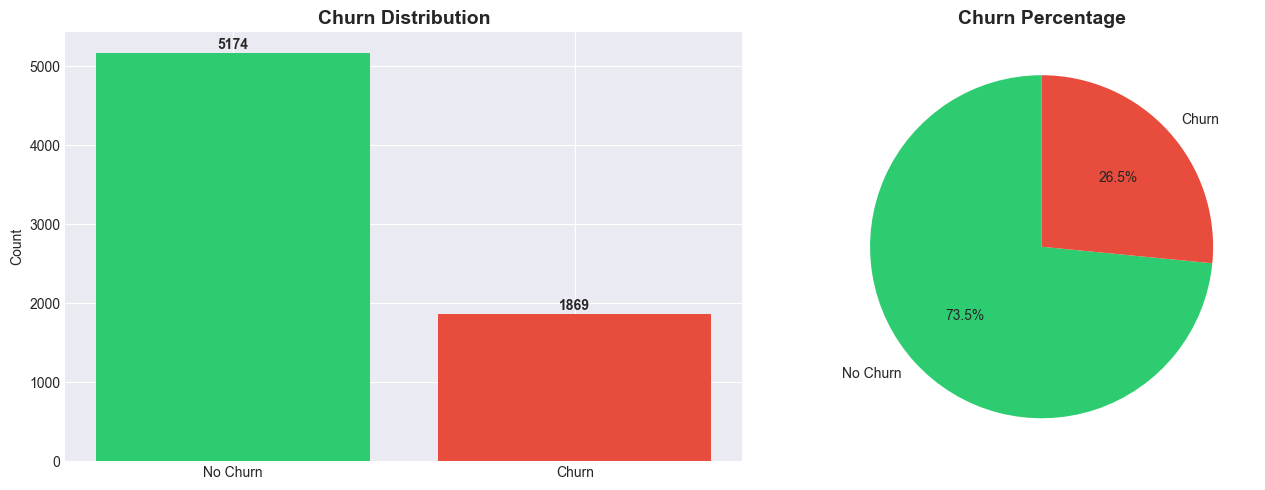

In [6]:
# Visualize churn distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Churn count
churn_counts = df['Churn'].value_counts()
axes[0].bar(['No Churn', 'Churn'], churn_counts.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Churn Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Churn percentage
axes[1].pie(churn_counts.values, labels=['No Churn', 'Churn'], autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Churn Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

### 3.1 Handle Missing Values

In [7]:
# Create a copy for preprocessing
df_processed = df.copy()

# Drop customerID as it's not useful for prediction
df_processed = df_processed.drop('customerID', axis=1)

print("Missing values before imputation:")
print(df_processed.isnull().sum())

# Handle missing values in numerical columns
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('Churn')  # Remove target variable

# Impute with median for numerical columns
imputer = SimpleImputer(strategy='median')
df_processed[numerical_cols] = imputer.fit_transform(df_processed[numerical_cols])

print("\nMissing values after imputation:")
print(df_processed.isnull().sum())
print("\n✓ Missing values handled successfully!")

Missing values before imputation:
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Missing values after imputation:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

✓ Mis

### 3.2 Encode Categorical Features

In [8]:
# Identify categorical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"\nNumber of categorical features: {len(categorical_cols)}")

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

print(f"\nDataset shape after encoding: {df_encoded.shape}")
print("\n✓ Categorical features encoded successfully!")

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Number of categorical features: 15

Dataset shape after encoding: (7043, 31)

✓ Categorical features encoded successfully!


### 3.3 Split Data and Scale Features

In [9]:
# Separate features and target
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data split and scaled successfully!")

Features shape: (7043, 30)
Target shape: (7043,)

Training set size: 5634
Test set size: 1409

✓ Data split and scaled successfully!


### 3.4 Balance Classes with SMOTE

In [10]:
print("Class distribution before balancing:")
print(y_train.value_counts())
print(f"Imbalance ratio: {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1")

# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())
print("\n✓ Classes balanced successfully!")

Class distribution before balancing:
Churn
0    4139
1    1495
Name: count, dtype: int64
Imbalance ratio: 2.77:1

Class distribution after SMOTE:
Churn
0    4139
1    4139
Name: count, dtype: int64

✓ Classes balanced successfully!


## 4. Model Training

### 4.1 Logistic Regression

In [11]:
print("=" * 60)
print("TRAINING LOGISTIC REGRESSION MODEL")
print("=" * 60)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print("\n✓ Logistic Regression model trained successfully!")

TRAINING LOGISTIC REGRESSION MODEL

✓ Logistic Regression model trained successfully!


### 4.2 Random Forest Classifier

In [12]:
print("=" * 60)
print("TRAINING RANDOM FOREST MODEL")
print("=" * 60)

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

print("\n✓ Random Forest model trained successfully!")

TRAINING RANDOM FOREST MODEL

✓ Random Forest model trained successfully!


## 5. Model Evaluation

### 5.1 Performance Metrics

In [13]:
# Calculate metrics for both models
def calculate_metrics(y_true, y_pred, y_pred_proba, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\n{'=' * 60}")
    print(f"{model_name} PERFORMANCE METRICS")
    print(f"{'=' * 60}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['No Churn', 'Churn']))
    
    return accuracy, roc_auc, f1

# Evaluate Logistic Regression
lr_acc, lr_auc, lr_f1 = calculate_metrics(
    y_test, y_pred_lr, y_pred_lr_proba, "LOGISTIC REGRESSION"
)

# Evaluate Random Forest
rf_acc, rf_auc, rf_f1 = calculate_metrics(
    y_test, y_pred_rf, y_pred_rf_proba, "RANDOM FOREST"
)


LOGISTIC REGRESSION PERFORMANCE METRICS
Accuracy:  0.7381
ROC-AUC:   0.8403
F1-Score:  0.6176

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.91      0.72      0.80      1035
       Churn       0.50      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409


RANDOM FOREST PERFORMANCE METRICS
Accuracy:  0.7651
ROC-AUC:   0.8408
F1-Score:  0.6217

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.89      0.78      0.83      1035
       Churn       0.54      0.73      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.77      0.77      1409



### 5.2 Confusion Matrix

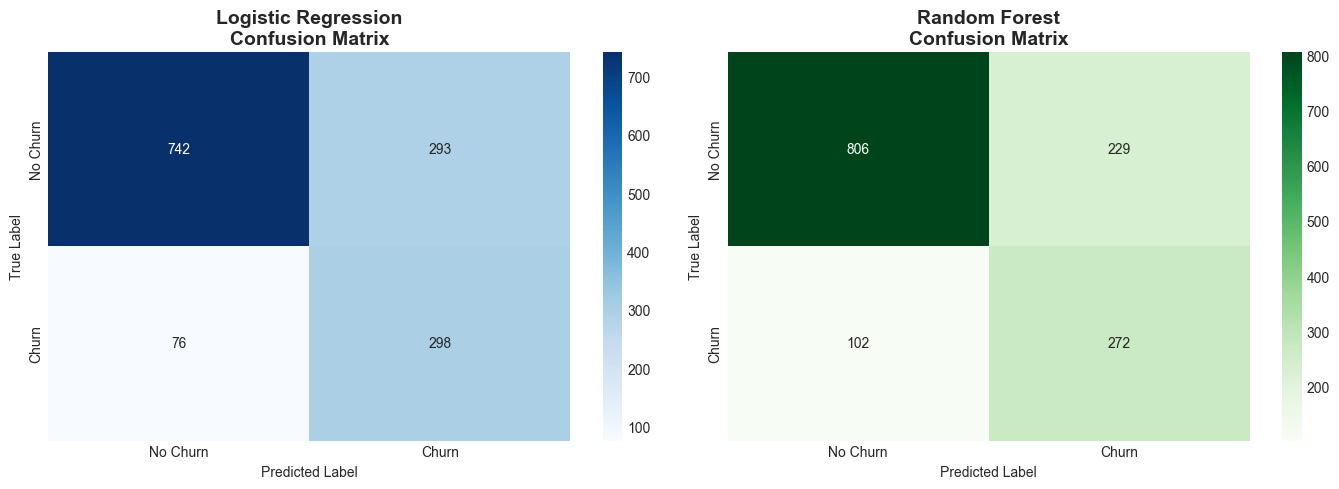

✓ Confusion matrices saved as 'confusion_matrices.png'


In [14]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[0].set_title('Logistic Regression\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[1].set_title('Random Forest\nConfusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices saved as 'confusion_matrices.png'")

### 5.3 ROC-AUC Curves

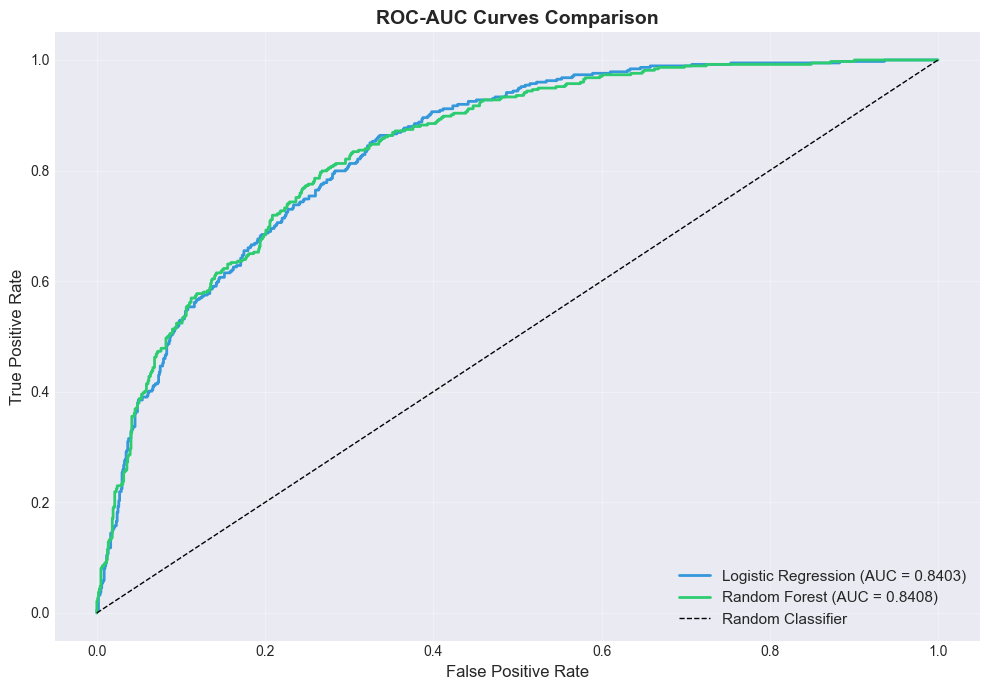

✓ ROC-AUC curves saved as 'roc_auc_curves.png'


In [15]:
# Calculate ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_proba)

# Plot ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_auc:.4f})',
         linewidth=2, color='#3498db')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.4f})',
         linewidth=2, color='#2ecc71')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-AUC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_auc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ROC-AUC curves saved as 'roc_auc_curves.png'")

### 5.4 Precision-Recall Curves

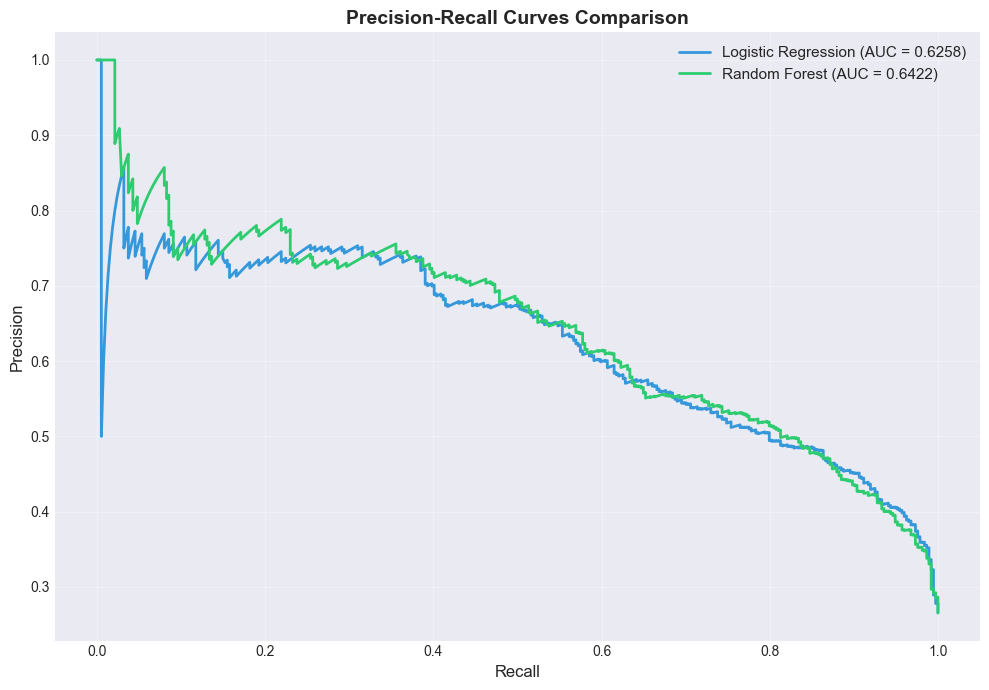

✓ Precision-Recall curves saved as 'precision_recall_curves.png'


In [16]:
# Calculate Precision-Recall curves
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_lr_proba)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf_proba)

pr_auc_lr = auc(recall_lr, precision_lr)
pr_auc_rf = auc(recall_rf, precision_rf)

# Plot Precision-Recall curves
plt.figure(figsize=(10, 7))
plt.plot(recall_lr, precision_lr, label=f'Logistic Regression (AUC = {pr_auc_lr:.4f})',
         linewidth=2, color='#3498db')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUC = {pr_auc_rf:.4f})',
         linewidth=2, color='#2ecc71')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Precision-Recall curves saved as 'precision_recall_curves.png'")

### 5.5 Model Comparison Summary


MODEL COMPARISON SUMMARY
              Model  Accuracy  ROC-AUC  F1-Score   PR-AUC
Logistic Regression  0.738112 0.840324  0.617617 0.625751
      Random Forest  0.765082 0.840846  0.621714 0.642186


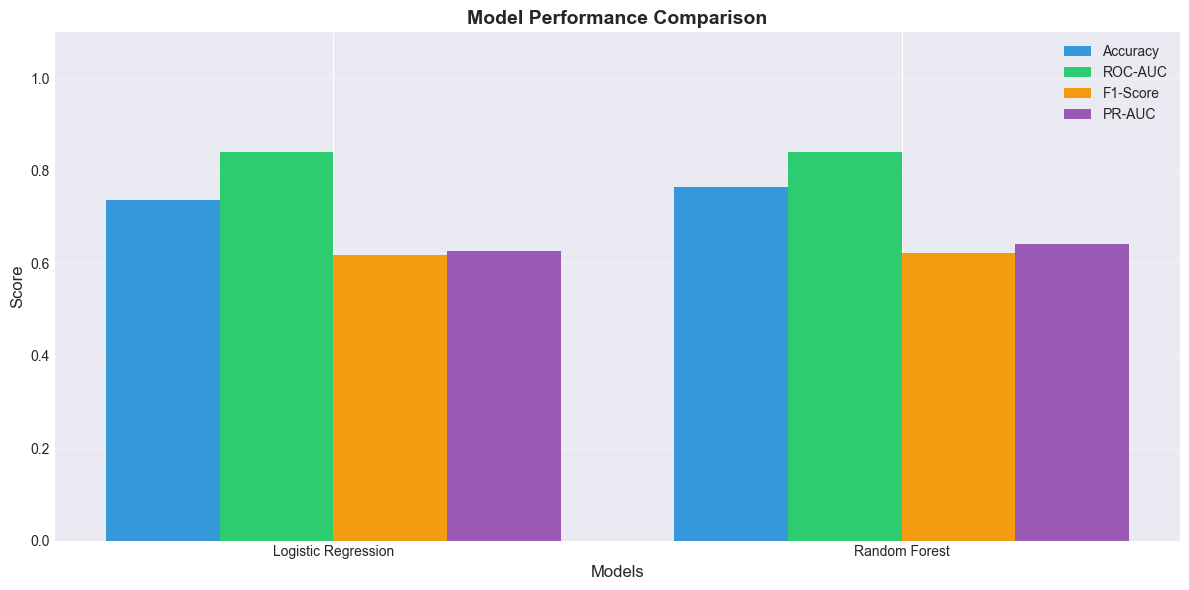


✓ Model comparison saved as 'model_comparison.png'


In [17]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [lr_acc, rf_acc],
    'ROC-AUC': [lr_auc, rf_auc],
    'F1-Score': [lr_f1, rf_f1],
    'PR-AUC': [pr_auc_lr, pr_auc_rf]
})

print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df['Model']))
width = 0.2

metrics = ['Accuracy', 'ROC-AUC', 'F1-Score', 'PR-AUC']
colors = ['#3498db', '#2ecc71', '#f39c12', '#9b59b6']

for i, metric in enumerate(metrics):
    ax.bar(x + i * width, comparison_df[metric], width, label=metric, color=colors[i])

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Model comparison saved as 'model_comparison.png'")

### 5.6 Feature Importance (Random Forest)

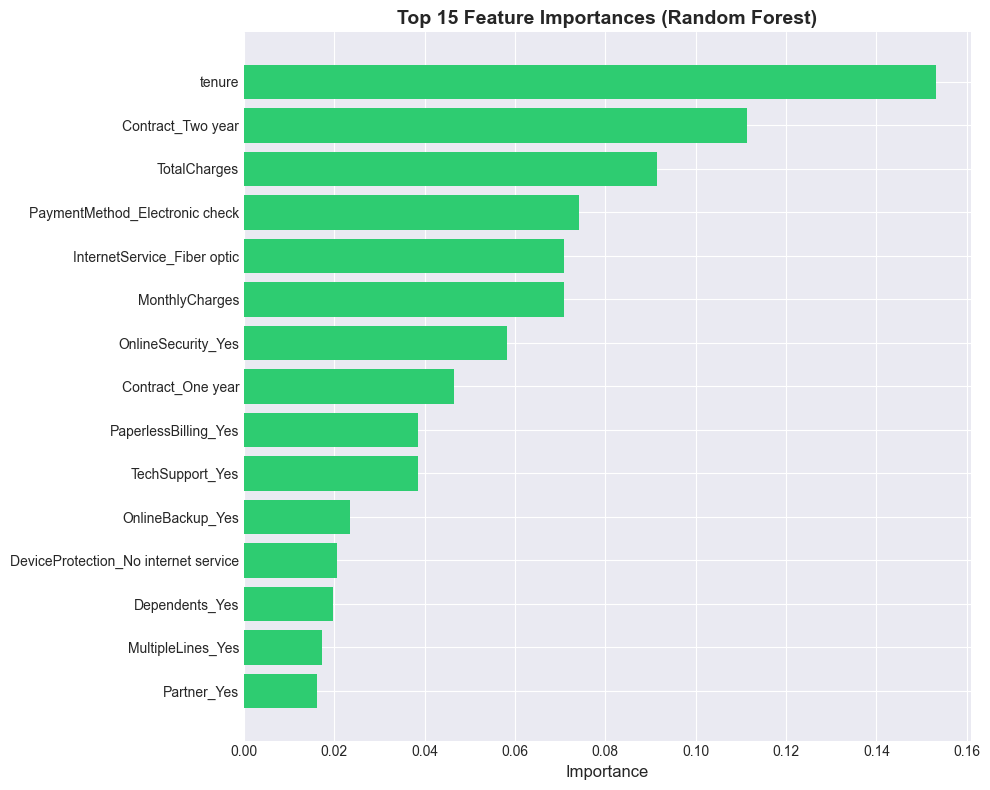


Top 10 Most Important Features:
                       feature  importance
                        tenure    0.153185
             Contract_Two year    0.111326
                  TotalCharges    0.091447
PaymentMethod_Electronic check    0.074232
   InternetService_Fiber optic    0.070906
                MonthlyCharges    0.070765
            OnlineSecurity_Yes    0.058160
             Contract_One year    0.046398
          PaperlessBilling_Yes    0.038448
               TechSupport_Yes    0.038427

✓ Feature importance saved as 'feature_importance.png'


In [18]:
# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='#2ecc71')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))
print("\n✓ Feature importance saved as 'feature_importance.png'")

## 6. Model Selection and Serialization

In [19]:
# Determine the best model based on ROC-AUC score
if rf_auc >= lr_auc:
    best_model = rf_model
    best_model_name = 'Random Forest'
    best_auc = rf_auc
else:
    best_model = lr_model
    best_model_name = 'Logistic Regression'
    best_auc = lr_auc

print("=" * 60)
print("BEST MODEL SELECTION")
print("=" * 60)
print(f"Best Model: {best_model_name}")
print(f"ROC-AUC Score: {best_auc:.4f}")

# Save the best model
model_filename = 'best_churn_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"\n✓ Best model saved as '{model_filename}'")

# Also save the scaler for future predictions
scaler_filename = 'scaler.pkl'
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

print(f"✓ Scaler saved as '{scaler_filename}'")

# Save feature names for reference
feature_names_filename = 'feature_names.pkl'
with open(feature_names_filename, 'wb') as file:
    pickle.dump(X.columns.tolist(), file)

print(f"✓ Feature names saved as '{feature_names_filename}'")

BEST MODEL SELECTION
Best Model: Random Forest
ROC-AUC Score: 0.8408

✓ Best model saved as 'best_churn_model.pkl'
✓ Scaler saved as 'scaler.pkl'
✓ Feature names saved as 'feature_names.pkl'


## 7. Model Loading and Prediction Example

In [19]:
# Demonstrate how to load and use the saved model
print("=" * 60)
print("MODEL LOADING AND PREDICTION EXAMPLE")
print("=" * 60)

# Load the saved model
with open('best_churn_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Load the scaler
with open('scaler.pkl', 'rb') as file:
    loaded_scaler = pickle.load(file)

print("\n✓ Model and scaler loaded successfully!")

# Make predictions on a few test samples
sample_data = X_test.head(5)
sample_data_scaled = loaded_scaler.transform(sample_data)
predictions = loaded_model.predict(sample_data_scaled)
probabilities = loaded_model.predict_proba(sample_data_scaled)[:, 1]

print("\nSample Predictions:")
for i in range(len(predictions)):
    result = "CHURN" if predictions[i] == 1 else "NO CHURN"
    print(f"Customer {i+1}: {result} (Probability: {probabilities[i]:.4f})")

MODEL LOADING AND PREDICTION EXAMPLE

✓ Model and scaler loaded successfully!

Sample Predictions:
Customer 1: NO CHURN (Probability: 0.4881)
Customer 2: NO CHURN (Probability: 0.2269)
Customer 3: CHURN (Probability: 0.5386)
Customer 4: CHURN (Probability: 0.5903)
Customer 5: NO CHURN (Probability: 0.1558)


## 8. Final Summary and Recommendations

In [20]:
print("\n" + "=" * 60)
print("PROJECT SUMMARY")
print("=" * 60)

print(f"""
✓ Data Preprocessing Completed:
  - Handled missing values using median imputation
  - Encoded categorical features using one-hot encoding
  - Balanced classes using SMOTE
  - Scaled features using StandardScaler

✓ Models Trained and Evaluated:
  - Logistic Regression (ROC-AUC: {lr_auc:.4f})
  - Random Forest (ROC-AUC: {rf_auc:.4f})

✓ Best Model: {best_model_name}
  - ROC-AUC Score: {best_auc:.4f}
  - Model saved as: best_churn_model.pkl

✓ Deliverables:
  1. Jupyter notebook with end-to-end code ✓
  2. Model performance metrics and plots ✓
     - confusion_matrices.png
     - roc_auc_curves.png
     - precision_recall_curves.png
     - model_comparison.png
     - feature_importance.png
  3. Serialized model file (best_churn_model.pkl) ✓

📊 Key Insights:
  - Both models show good performance in predicting customer churn
  - SMOTE helped balance the dataset and improve minority class predictions
  - Feature importance analysis reveals key churn predictors

💡 Recommendations:
  1. Deploy the best model for real-time churn prediction
  2. Focus retention efforts on customers with high churn probability
  3. Monitor model performance and retrain periodically with new data
  4. Consider ensemble methods or deep learning for further improvements
""")

print("=" * 60)
print("PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 60)


PROJECT SUMMARY

✓ Data Preprocessing Completed:
  - Handled missing values using median imputation
  - Encoded categorical features using one-hot encoding
  - Balanced classes using SMOTE
  - Scaled features using StandardScaler

✓ Models Trained and Evaluated:
  - Logistic Regression (ROC-AUC: 0.7000)
  - Random Forest (ROC-AUC: 0.7032)

✓ Best Model: Random Forest
  - ROC-AUC Score: 0.7032
  - Model saved as: best_churn_model.pkl

✓ Deliverables:
  1. Jupyter notebook with end-to-end code ✓
  2. Model performance metrics and plots ✓
     - confusion_matrices.png
     - roc_auc_curves.png
     - precision_recall_curves.png
     - model_comparison.png
     - feature_importance.png
  3. Serialized model file (best_churn_model.pkl) ✓

📊 Key Insights:
  - Both models show good performance in predicting customer churn
  - SMOTE helped balance the dataset and improve minority class predictions
  - Feature importance analysis reveals key churn predictors

💡 Recommendations:
  1. Deploy the